In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
import base64
from glob import glob
from collections import defaultdict
from collections import Counter

from lib import LogTorPSMultiple
from lib import Log
from lib import Simulation
from lib import Consensus
from lib import Stat

from lib import ACTIVE_CIRCUITS_PER_SECOND
from lib import ACTIVE_CIRCUITS_PER_SECOND_STD

from lib import convert_fingerprint_base64_to_hex
from lib import convert_fingerprint_hex_to_base64

from stem.descriptor import parse_file
from tqdm.notebook import tqdm

# Simplified self-contained implementation of SALSA

It is called "Pseudo", because it is the precursor for the pseudo code in the paper.

In [2]:
import numpy as np
from collections import defaultdict
from glob import glob
from stem.descriptor import DocumentHandler, parse_file


# function is from TorPS
def get_weight(flags, position, bw_weights):    
    if (position == 'G'):
        if ('Guard' in flags) and ('Exit' in flags):
            weight = bw_weights['Wgd']
        elif ('Guard' in flags):
            weight = bw_weights['Wgg']
        elif ('Exit' not in flags):
            weight = bw_weights['Wgm']
        else:
            weight = 0.0
    elif (position == 'M'):
        if ('Guard' in flags) and ('Exit' in flags):
            weight = bw_weights['Wmd']
        elif ('Guard' in flags):
            weight = bw_weights['Wmg']
        elif ('Exit' in flags):
            weight = bw_weights['Wme']
        else:
            weight = bw_weights['Wmm']
    elif (position == 'E'):
        if ('Guard' in flags) and ('Exit' in flags):
            weight = bw_weights['Wed']
        elif ('Guard' in flags):
            weight = bw_weights['Weg']
        elif ('Exit' in flags):
            weight = bw_weights['Wee']
        else:
            weight = bw_weights['Wem']
    else:
        assert False

    return float(weight) / 10000.0


def read_consensus(filename):
    consensus = next(parse_file(
        filename,
        descriptor_type = 'network-status-consensus-3 1.0',
        document_handler = DocumentHandler.DOCUMENT,
    ))

    bw_weights = consensus.bandwidth_weights
    
    N_relays = 0
    P_guards = []
    P_middles = []
    P_exits = []
    for _, relay in consensus.routers.items():
        N_relays += 1
                
        if 'Guard' in relay.flags or 'Exit' in relay.flags:
            P_guards.append(relay.bandwidth * get_weight(relay.flags, 'G', bw_weights))            
        else:                        
            P_guards.append(0.0)
            
        P_middles.append(relay.bandwidth * (get_weight(relay.flags, 'M', bw_weights)))        

        if 'Exit' in relay.flags:
            P_exits.append(relay.bandwidth * (get_weight(relay.flags, 'E', bw_weights)))            
        else:
            P_exits.append(0.0)
                        
    assert len(P_guards) == N_relays
    assert len(P_middles) == N_relays
    assert len(P_exits) == N_relays
    
    P_guards = np.array(P_guards)
    P_middles = np.array(P_middles)
    P_exits = np.array(P_exits)
    
    P_guards /= P_guards.sum()
    P_middles /= P_middles.sum()
    P_exits /= P_exits.sum()
    
    return N_relays, P_guards, P_middles, P_exits


def count_shared(links, left, right, directed):    
    shared = 0
    for k in zip(left, right):
        if not directed:
            k = frozenset(k)
        links[k] += 1
        if links[k] == 2:
            shared += 1
    return shared


def simulate(N_relays, P_guard, P_middle, P_exit, N_circuits, k, internal, directed):
    assert len(P_guard) == N_relays
    assert len(P_middle) == N_relays
    assert len(P_exit) == N_relays    
    assert N_circuits % k == 0
    
    entries = np.random.choice(np.arange(N_relays), N_circuits // k, p=P_guard)    
    entries = np.repeat(entries, k)
    
    middles = np.random.choice(np.arange(N_relays), N_circuits, p=P_middle)
    
    if internal:
        exits = np.random.choice(np.arange(N_relays), N_circuits, p=P_middle)
    else:        
        exits = np.random.choice(np.arange(N_relays), N_circuits, p=P_exit)
        
    assert len(entries) == N_circuits
    assert len(middles) == N_circuits
    assert len(exits) == N_circuits
        
    links = defaultdict(int)
    shared = 0
    shared += count_shared(links, entries, middles, directed)
    shared += count_shared(links, middles, exits, directed)
    
    return shared / len(links) * 100

## Test

The difference between SALSA and SALSA (pseudo) should be close to zero.

In [3]:
N = ACTIVE_CIRCUITS_PER_SECOND // 8 * 8

result_pseudo = []
result = []

for filename in tqdm(glob('./../data/2021-11-*-00-02-00/cached-microdesc-consensus')):   
    c1 = read_consensus(filename)
    c2 = Consensus.read(filename)
    for k in [1, 2, 8]:
        for internal in [False, True]:
            for directed in [False, True]:
                for _ in range(2):
                    result_pseudo.append(simulate(*c1, N, k, internal, directed))
                    result.append(float(Simulation.from_consensus(c2, N=N, k=k, is_internal=internal, directed_links=directed).simulate().stat.create_table()['Shared Links Percent']))
    
df = pd.DataFrame(dict(pseudo=result_pseudo, normal=result))
df['diff'] = df['normal'] - df['pseudo']
df['diff'].mean()

  0%|          | 0/30 [00:00<?, ?it/s]

-0.0033755032879232627

# Load or generate circuits for SALSA, SALSA (pseudo), ModTor and TorPS

In [4]:
ACTIVE_CIRCUITS_PER_SECOND

96876

In [5]:
torps_logs = LogTorPSMultiple.read(
    "./../data/log.2021-11.torps", 
    take_n=ACTIVE_CIRCUITS_PER_SECOND, 
    split_every_n=200_000
)

In [6]:
torps_stats = []
for log in torps_logs:
    torps_stats.append(log.stat)

In [7]:
tormod_logs = []
for log in sorted(glob('./../data/2021-11-*-00-02-00/log')):
    tormod_logs.append(Log.read(log, take_n=ACTIVE_CIRCUITS_PER_SECOND))

In [8]:
tormod_stats = []
for log in tormod_logs:
    tormod_stats.append(log.stat)

In [9]:
sim_stats = []
for consensus in sorted(glob('./../archive/microdescs-2021-11/consensus-microdesc/*/2021-11-*-00-00-00-consensus-microdesc')):
    c = Consensus.read(consensus)
    sim = Simulation.from_consensus(c, N=ACTIVE_CIRCUITS_PER_SECOND).simulate()
    sim_stats.append(sim.stat)

In [10]:
table = defaultdict(list)
for stat in torps_stats:
    table['Name'].append('TorPS')    
    table['Total Circuits'].append(float(stat.create_table()['Total Circuits']))
    table['Shared Links Percent'].append(float(stat.create_table()['Shared Links Percent']))
for stat in tormod_stats:
    table['Name'].append('ModTor')
    table['Total Circuits'].append(float(stat.create_table()['Total Circuits']))
    table['Shared Links Percent'].append(float(stat.create_table()['Shared Links Percent']))
for stat in sim_stats:
    table['Name'].append('SALSA')
    table['Total Circuits'].append(float(stat.create_table()['Total Circuits']))
    table['Shared Links Percent'].append(float(stat.create_table()['Shared Links Percent']))
for consensus in sorted(glob('./../data/2021-11-*-00-02-00/cached-microdesc-consensus')):
    table['Name'].append('Pseudo')
    table['Total Circuits'].append(0)
    table['Shared Links Percent'].append(simulate(*read_consensus(consensus), ACTIVE_CIRCUITS_PER_SECOND, 1, False, True))

In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Add family members to consensus relays from microdescriptors

In [12]:
def family_member_to_base64(f):
    if f[0] == '$':
        return convert_fingerprint_hex_to_base64(f[1:])
    else:
        return f
    
def add_family_members_column(df):
    family_members = []
    for digest in list(df['DigestHex']):
        filenames = glob(f'./../archive/microdescs-2021-11/micro/*/*/{digest.lower()}')        
        assert len(filenames) == 1
        desc = next(parse_file(filenames[0]))
        family_members.append([family_member_to_base64(f) for f in desc.family])
    df['FamilyMembers'] = family_members
    
add_family_members_column(c.df)

In [13]:
c.df.head()

Nickname   Version         Address  \
ID                                                                        
AAoQ1DAR6kkoo19hBAX5K0QztNw             seele   0.4.6.8   98.45.181.220   
ABG9JIWtRdmE7EFZyI/AZuXjMA4  CalyxInstitute14   0.4.5.7  162.247.74.201   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8           Honorem   0.4.6.8    65.21.66.166   
ACQOyytTWqTB4YdNdE36avLl6UE      skylarkRelay  0.4.5.10  95.111.230.178   
ACg7VWTjBy3N2rMdbvYi3Um/Uk8    StarAppsMobley   0.4.6.8   195.15.242.99   

                              Subnet  \
ID                                     
AAoQ1DAR6kkoo19hBAX5K0QztNw    98.45   
ABG9JIWtRdmE7EFZyI/AZuXjMA4  162.247   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8    65.21   
ACQOyytTWqTB4YdNdE36avLl6UE   95.111   
ACg7VWTjBy3N2rMdbvYi3Um/Uk8   195.15   

                                                                     DigestHex  \
ID                                                                               
AAoQ1DAR6kkoo19hBAX5K0QztNw  F6D7D67A877129AED942799D9054F4FCD7BF3EB015EA02...   
ABG9JIWtRdmE7EFZyI/AZuXjMA4  202B97ED681B4AF0C0BAD16981EAEEB24366A7C080E96C...   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8  A5C9DE188C74DCC3695143EF032870A70F871DF9E95729...   
ACQOyytTWqTB4YdNdE36avLl6UE  3038542762A5A2B635125C4D9EB41702521D0DA9273A74...   
ACg7VWTjBy3N2rMdbvYi3Um/Uk8  43E96F1B1103130C06DAAC19323456F4F256FCE393A648...   

                              Fast  Authority  Guard  Middle   Exit  V2Dir  \
ID                                                                           
AAoQ1DAR6kkoo19hBAX5K0QztNw  False      False  False    True  False   True   
ABG9JIWtRdmE7EFZyI/AZuXjMA4   True      False   True   False   True   True   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8   True      False  False    True  False   True   
ACQOyytTWqTB4YdNdE36avLl6UE   True      False   True   False  False   True   
ACg7VWTjBy3N2rMdbvYi3Um/Uk8   True      False  False    True  False   True   

                             Stable  HSDir  BadExit  StaleDesc  Running  \
ID                                                                        
AAoQ1DAR6kkoo19hBAX5K0QztNw    True  False    False      False     True   
ABG9JIWtRdmE7EFZyI/AZuXjMA4    True   True    False      False     True   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8    True  False    False      False     True   
ACQOyytTWqTB4YdNdE36avLl6UE    True   True    False      False     True   
ACg7VWTjBy3N2rMdbvYi3Um/Uk8    True  False    False      False     True   

                             Valid  Bandwidth  Unmeasured  WeightForGuard  \
ID                                                                          
AAoQ1DAR6kkoo19hBAX5K0QztNw   True         10       False             0.0   
ABG9JIWtRdmE7EFZyI/AZuXjMA4   True      16900       False             0.0   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8   True      26700       False             0.0   
ACQOyytTWqTB4YdNdE36avLl6UE   True      12000       False          7080.0   
ACg7VWTjBy3N2rMdbvYi3Um/Uk8   True      53000       False             0.0   

                             WeightForMiddle  WeightForExit  ProbForGuard  \
ID                                                                          
AAoQ1DAR6kkoo19hBAX5K0QztNw             10.0            0.0      0.000000   
ABG9JIWtRdmE7EFZyI/AZuXjMA4              0.0        16900.0      0.000000   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8          26700.0            0.0      0.000000   
ACQOyytTWqTB4YdNdE36avLl6UE           4920.0            0.0      0.000248   
ACg7VWTjBy3N2rMdbvYi3Um/Uk8          53000.0            0.0      0.000000   

                             ProbForMiddle  ProbForExit  SubnetCount  \
ID                                                                     
AAoQ1DAR6kkoo19hBAX5K0QztNw   3.508403e-07     0.000000            1   
ABG9JIWtRdmE7EFZyI/AZuXjMA4   0.000000e+00     0.000623           13   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8   9.367437e-04     0.000000           11   
ACQOyytTWqTB4YdNdE36avLl6UE   1.726134e-04     0.000000            6   
ACg7VWTjBy3N2rMdbvYi3Um/Uk8   1.859454e-03     0.000000            5  

## Test: Filter out circuits that contain an relay more than once, contain two or more relays with the same family or contain two or more relays with the same subnet

In [14]:
counts = defaultdict(int)

def check(df, func, relays):
    return func(df, relays[0], relays[1]) or func(df, relays[0], relays[2]) or func(df, relays[1], relays[2])

def same_relay(df, left, right):
    return left == right

def same_family(df, left, right):    
    is_fingerprint = left in df.loc[right]['FamilyMembers'] or right in df.loc[left]['FamilyMembers']    
    is_nickname = df.loc[left]['Nickname'] in df.loc[right]['FamilyMembers'] or df.loc[right]['Nickname'] in df.loc[left]['FamilyMembers']

    if is_fingerprint:
        counts['is_fingerprint'] += 1
    if is_nickname:
        counts['is_nickname'] += 1
        
    return is_fingerprint or is_nickname

def same_subnet(df, left, right):
    return df.loc[left]['Subnet'] == df.loc[right]['Subnet']


c = Consensus.read(glob('./../archive/microdescs-2021-11/consensus-microdesc/*/2021-11-*-00-00-00-consensus-microdesc')[1])
sim = Simulation.from_consensus(c, N=round(ACTIVE_CIRCUITS_PER_SECOND*1.1)).simulate()
add_family_members_column(c.df)


i = 0
circuits = []
for relays, count in tqdm(sim.stat.circuits.items()):
    try:
        fine = True
        if check(c.df, same_relay, relays): 
            counts['same_relay'] += count         
            fine = False
        if check(c.df, same_family, relays):
            counts['same_family'] += count
            fine = False
        if check(c.df, same_subnet, relays):
            counts['same_subnet'] += count
            fine = False
        if fine:
            circuits.append(relays)
        else:
            counts['not_fine'] += count
    except KeyError:
        counts['key_error'] += count
        
counts

  0%|          | 0/106555 [00:00<?, ?it/s]

defaultdict(int,
            {'same_subnet': 626,
             'not_fine': 785,
             'is_fingerprint': 228,
             'same_family': 228,
             'same_relay': 30})

In [15]:
len(sim.stat.circuits)

106555

### Results

The comparision between SALSA and SALSA (pseudo) shows that relay family and subnets have no significant influence on shared links.

In [16]:
stat = Stat.create(circuits[0:ACTIVE_CIRCUITS_PER_SECOND], date='Filtered')
stat1 = Stat.create(list(sim.stat.circuits.keys())[0:ACTIVE_CIRCUITS_PER_SECOND], date='Normal')
pd.concat([stat.create_table(), stat1.create_table()]).T

Date                                    Filtered         Normal
Total Circuits                      96876.000000   96876.000000
Total Links                        185607.000000  185601.000000
Shared Links                         7305.000000    7318.000000
Unshared Links                     178302.000000  178283.000000
Shared Links Percent                    3.935735       3.942867
Total Circuit Parts                193752.000000  193752.000000
Shared Circuit Parts                15450.000000   15469.000000
Unshared Circuit Parts             178302.000000  178283.000000
Shared Circuit Parts Percent            7.974111       7.983918
Total Guard-Middle Links            94216.000000   94215.000000
Shared Guard-Middles Links           2520.000000    2526.000000
Unshared Guard-Middles Links        91696.000000   91689.000000
Shared Guard-Middles Percent            2.674705       2.681102
Total Middle-Exits Links            91391.000000   91386.000000
Shared Middle-Exits Links            4785.000000    4792.000000
Unshared Middle-Exits Links         86606.000000   86594.000000
Shared Middle-Exits Links Percent       5.235745       5.243692
Complete Shared Circuits                0.000000       0.000000
Relays                               5715.000000    5713.000000
Guards                               2441.000000    2441.000000
Middles                              4437.000000    4435.000000
Exits                                1258.000000    1258.000000

# Why does TorPS differ from SALSA or ModTor

In [17]:
torps_guards = np.array(list(torps_stats[1].guards.keys()))
sim_guards = np.array(list(sim_stats[1].guards.keys()))
mod_guards = np.array(list(tormod_stats[1].guards.keys()))

for idx, fingerprint in enumerate(torps_guards):
    torps_guards[idx] = convert_fingerprint_hex_to_base64(fingerprint)

In [18]:
torps_middles = np.array(list(torps_stats[1].middles.keys()))
sim_middles = np.array(list(sim_stats[1].middles.keys()))
mod_middles = np.array(list(tormod_stats[1].middles.keys()))

for idx, fingerprint in enumerate(torps_middles):
    torps_middles[idx] = convert_fingerprint_hex_to_base64(fingerprint)

In [19]:
c.df[~c.df.index.isin(torps_guards)].head()

Nickname   Version         Address  \
ID                                                                        
AAoQ1DAR6kkoo19hBAX5K0QztNw             seele   0.4.6.8   98.45.181.220   
ABG9JIWtRdmE7EFZyI/AZuXjMA4  CalyxInstitute14   0.4.5.7  162.247.74.201   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8           Honorem  0.4.5.10    65.21.66.166   
ADv6G2zFy+/V0Agvj8mvKohoqPs      xX0seamus0Xx   0.4.4.5  188.214.132.49   
AEtDijlcW30O+PquBW+poct6u4Y          Tatita23   0.4.6.7     51.15.45.73   

                              Subnet  \
ID                                     
AAoQ1DAR6kkoo19hBAX5K0QztNw    98.45   
ABG9JIWtRdmE7EFZyI/AZuXjMA4  162.247   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8    65.21   
ADv6G2zFy+/V0Agvj8mvKohoqPs  188.214   
AEtDijlcW30O+PquBW+poct6u4Y    51.15   

                                                                     DigestHex  \
ID                                                                               
AAoQ1DAR6kkoo19hBAX5K0QztNw  12E4A1E4B0C7A610E10E24C5B506E2BBB19CF5325A436D...   
ABG9JIWtRdmE7EFZyI/AZuXjMA4  62E342623B132093EA7E42F4012542D5FB144E4CAB96BB...   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8  BC781DF9AD480CE0AA1BF7CD40CBBFF16377ABF73BBF0B...   
ADv6G2zFy+/V0Agvj8mvKohoqPs  3572EBA4AA41F622A072151F2F9A23DECC9086269572D3...   
AEtDijlcW30O+PquBW+poct6u4Y  8191AF9D41EF86EDDB7BDADCADB41D83AC4977D43CDF37...   

                              Fast  Authority  Guard  Middle   Exit  V2Dir  \
ID                                                                           
AAoQ1DAR6kkoo19hBAX5K0QztNw  False      False  False    True  False   True   
ABG9JIWtRdmE7EFZyI/AZuXjMA4   True      False   True   False   True   True   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8   True      False  False    True  False   True   
ADv6G2zFy+/V0Agvj8mvKohoqPs   True      False   True   False  False   True   
AEtDijlcW30O+PquBW+poct6u4Y   True      False  False    True  False   True   

                             Stable  HSDir  BadExit  StaleDesc  Running  \
ID                                                                        
AAoQ1DAR6kkoo19hBAX5K0QztNw    True  False    False      False     True   
ABG9JIWtRdmE7EFZyI/AZuXjMA4    True   True    False      False     True   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8   False  False    False      False     True   
ADv6G2zFy+/V0Agvj8mvKohoqPs    True  False    False      False     True   
AEtDijlcW30O+PquBW+poct6u4Y    True   True    False      False     True   

                             Valid  Bandwidth  Unmeasured  WeightForGuard  \
ID                                                                          
AAoQ1DAR6kkoo19hBAX5K0QztNw   True         18       False             0.0   
ABG9JIWtRdmE7EFZyI/AZuXjMA4   True      17000       False             0.0   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8   True          1       False             0.0   
ADv6G2zFy+/V0Agvj8mvKohoqPs   True      24000       False         16020.0   
AEtDijlcW30O+PquBW+poct6u4Y   True        490       False             0.0   

                             WeightForMiddle  WeightForExit  ProbForGuard  \
ID                                                                          
AAoQ1DAR6kkoo19hBAX5K0QztNw             18.0            0.0      0.000000   
ABG9JIWtRdmE7EFZyI/AZuXjMA4              0.0        17000.0      0.000000   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8              1.0            0.0      0.000000   
ADv6G2zFy+/V0Agvj8mvKohoqPs           7980.0            0.0      0.000605   
AEtDijlcW30O+PquBW+poct6u4Y            490.0            0.0      0.000000   

                             ProbForMiddle  ProbForExit  SubnetCount  \
ID                                                                     
AAoQ1DAR6kkoo19hBAX5K0QztNw   6.850845e-07     0.000000            1   
ABG9JIWtRdmE7EFZyI/AZuXjMA4   0.000000e+00     0.001137           13   
ACLHOZ3j5cj2t0ziooOZ1ScmSF8   3.806025e-08     0.000000           22   
ADv6G2zFy+/V0Agvj8mvKohoqPs   3.037208e-04     0.000000            2   
AEtDijlcW30O+PquBW+poct6u4Y   1.864952e-05     0.000000           84  

In [20]:
len(c.df[(c.df['Guard']) & ~c.df['Exit']]), len(c.df[c.df.index.isin(mod_guards)]), len(c.df[c.df.index.isin(sim_guards)]), len(c.df[c.df.index.isin(torps_guards)])

(2444, 2446, 2441, 2308)

In [21]:
len(c.df[((c.df['Guard']) & ~c.df['Exit']) | (c.df['Middle'])]), len(c.df[c.df.index.isin(mod_middles)]), len(c.df[c.df.index.isin(sim_middles)]), len(c.df[c.df.index.isin(torps_middles)])

(5414, 4474, 4444, 4393)

In [22]:
len(c.df[c.df.index.isin(mod_guards) & ~c.df.index.isin(torps_guards)])

138

In [23]:
len(c.df[c.df.index.isin(mod_middles) & ~c.df.index.isin(torps_middles)])

249

In [24]:
c.df[c.df.index.isin(mod_guards) & ~c.df.index.isin(torps_guards)]

Nickname        Version  \
ID                                                                
ADv6G2zFy+/V0Agvj8mvKohoqPs         xX0seamus0Xx        0.4.4.5   
BMNGi+JHQDR8vMAFNMlA28vKvII           aaron0x10c       0.4.5.10   
BO5eGyMSfSajb3HGaBDYiwuAu5E              dorinne       0.3.5.14   
By5OxH1kARjVQ4v/3/Gve7TirSs             Shebangs       0.3.5.10   
E/fq5zHKRgCVGYaSHgjsq5sdKvY             CanopoIT        0.4.5.9   
FEParwn0eHXZIvcYyMyJqIxQs/U        UrbanTorRelay        0.4.5.6   
FTBCM2IiFD1nvz0DySVX+Rsa2Go           plithismos       0.4.5.10   
GlNwC9Hz579suxtvyz9Ksy+IyRU               pjahra        0.4.6.8   
HKgRR4qzD13oCCXhX5WvGNzTKy8             mig5rezo        0.4.6.8   
JK8WA8300Rjh966/aAwYvaXo95M                 fury       0.3.5.12   
K88b/LcUc7eNRLzRjIU49AbeMM0       fiedlerRelay01        0.4.6.8   
L5r95D3I4/BYAzBMAb09vzKRaaw             dutreuil       0.4.5.10   
N92bZwlK52/V4hVL5yZMxFPrY/g           blueblazer        0.4.5.9   
ORDFygzFr+IscJ30caK1trSu3Jg          criticalcat        0.4.5.9   
Ou58AJeJpCnYISPeX9iydjtGVvA         Assange037us       0.4.5.10   
O2Xuo924kM9ImeZ1p7E40EdZ+vo       fiedlerRelay10        0.4.6.8   
O6TH27WRIn1Bg1D0MaYVCRQN93E             torpoker       0.3.5.14   
PVLAqoLl0OJlNJ/EikrcAwJ0xBw            DTFNODE62       0.4.5.10   
QBHhuw5bmiKvZltVO//d4ipRexY              ramhorn        0.4.5.9   
QNEwlrvRGvGYzmHe5OrszlRy8uc   OhNoAnotherRelay02       0.4.5.10   
QSdn7LDO99y6+HSN26hXWGDdZ4I         winterferien        0.4.6.6   
QgVeOpAwtA5qLWXh9LxE9Rh4ArU                  SIS       0.4.5.10   
Q48+pMn7DbY/U3ejJxq1Q1+tfgQ             dolemite        0.3.5.8   
RfHO3Q2Bviv5CKfO+Op5lIbkIgY                 Sw4n        0.4.5.7   
RfgM/OD/ZergEgSbr2YIT3bm1os          Machiavelli       0.4.5.10   
RmHeltP46SOZSwUhjyN2DI15NaQ           toritounam       0.3.5.15   
SRikYc7hyOZfQnLkDPPGxucLsiw             Shebangs       0.3.5.14   
SVtJaGfIS7ySM4MB2SSFDyJuddo      AnotherTorRelay        0.4.6.8   
TdEcPxH14okdV++fffQ77htRT84           diodeOnion        0.4.5.6   
TqOBocr0QiwUIBtL95kDmUKpf/0              estrade        0.4.5.9   
TsvzfklT9IqgLKMK6Sl4khiwfIA             fuzzycat        0.4.6.5   
UCd0ugRm066benoOoiWcxiuDmKk              galates        0.4.6.7   
UE8j3HNEWdu6WLLxGkeZ65RRiKM             whiplash        0.4.5.9   
UaiiKUTyKOotYBQ00SeGSxsLD4w         notoriousgib       0.3.5.14   
UqIi2nGmDfU+uT9Pe8Py1fgDj08            DTFNODE23       0.4.5.10   
U7N59AY7O5GySn3/zC9lM/UbMkU           Nicodeamuz        0.4.5.9   
U7+W+FBvgd18UEKVzATvNblHfOs     BestofbestLinode        0.4.4.5   
VYBPnTf3snvQQms8sGxktND5VUY   DeezNode3877619345       0.4.5.10   
WTQHl4+I59K0UEVnbnw3krwsmZg            DTFNODE77       0.4.5.10   
XyiN5X33wtxK7vgMC3QZNJcufWA   MoreDrugsMoreBikes       0.4.5.10   
X+g60Qa0mNWj6npI+3N0mvKJfls             kohlhaas       0.3.5.14   
YNErfXpgFiJQT3TJpOt8jzP+XIQ             Shebangs       0.3.5.14   
YidKwX3M9AMKatjOvtDDbnuFktg       fiedlerRelay08        0.4.6.8   
Y+CUpUR3mWc8EUETQFj5SAdOqmM               ESCAPE        0.4.4.6   
ZX0vTddtG6eHfrLxdC7ZiY6wRik              Asakusa        0.4.4.5   
ZeQPft0o4s8oaE4w4Lq3cGgZz8M               Fangio        0.4.5.8   
Z18F/ezx3Pg27SdNZevpGcR0O5E       fiedlerRelay06        0.4.6.8   
bEmq3qV9OdyP96d6oy8mj9xC4qM         uqtilephataz        0.4.5.6   
bxojFMShre37fUGba7ENe8QBGfY               leysen        0.4.4.6   
b3KYcYfrSCI5lb76chdVkyZg0Nc            DTFNODE75       0.4.5.10   
dVXb2XMu9m8PCExB39pAG20DZQU        gbhfmoldrelay        0.4.5.7   
djmHfhPouk6o/COjgkuaArw+1OA      FictionEndevour        0.4.4.6   
dlvVu0sV8zLC1UA8lSuZXXPlCg0                 Rus1       0.4.5.10   
eLbhksrD8W8SyJgGm7ydd6dGhrY            OregaOchi        0.4.2.7   
es5xUMMcJ3w/Zc7d/4UTt14h/wk           daTORrelay        0.4.5.8   
f/lDIJY7XNr5oHLOm+6bTx8rODw             lebreton        0.4.5.8   
guwDvexGXpus3RGawLc5atbcByA              Unnamed       0.4.5.10   
hw6X5YRtgwjqRppbtaUNKDhQPb4              griffin       0.3.5.16   
iRFSXAcTQX6e0lSFqUkk

In [25]:
c.df[c.df.index.isin(mod_middles) & ~c.df.index.isin(torps_middles)]

Nickname            Version  \
ID                                                                    
AX2Xuw8oHDSXIJHAeSvycZi2dOU               raptor            0.4.5.9   
AdcItBd93de58aQaMIHzMPuO8Dg              Unnamed           0.3.5.10   
A+n35mnI+RHF7sPsCUUzFR+FdCA        4pyro2eu3org0           0.3.5.14   
Bk0YPTTey4T3LEM1sMJNHolGqbo              TheYOSH            0.4.6.8   
BxKIshgnEeUoQkgTcEjg+7+zYjM            LaTlayuda           0.3.5.16   
CtjBW5MK0fMysd/6N3m31BtF2+A                 Kabo            0.4.4.6   
C80qmap2wJhfwoFAznEFSccKwP0              Unnamed           0.4.5.10   
DYh3OS8v9a2NjlvEOAh/Au+XuQQ            Starlight            0.4.6.7   
Df/l0oRsU3lOnEuren1r2sBzKFs           82320e8da3            0.4.5.6   
DwXpahEJ3KIha2Nl1X9kgmwpvCI                polux           0.3.5.15   
D6YXiuOcQT/mV2Qt3Alck7GEKnk            NaruOTORI            0.4.6.7   
EUxDsrrViIYbx6g/qYiezE9Ohe8                hashy           0.4.5.10   
FX7kWhIKmy8ZZzqAQBvNFj7mG0U           FuckTheNSA           0.4.5.10   
FdipWO/g8TDzNbCISgiQK5BfL8E              Unnamed            0.4.5.9   
GUj+9SiX9qJeRWt9ucLTfvtyUME              badabim            0.4.6.8   
GcAZ5HMDrZtz4hiWajV7vZmx/Ag             BitlBee1            0.4.6.6   
HCEmjS5tXJU7XuEDQG1FWyW3kik              Unnamed            0.4.6.8   
HHbhMrl+8KA4dGR95lunSDRpwns          RegnalOrton           0.4.5.10   
HmPCztO23c0QeLKk8QyKSL0sMaA          Blankenship           0.4.5.10   
HnC5JT4z0y9ps4C3xasEdfIt00k              Unnamed           0.4.5.10   
Hw7lDdtglSgcqWvsgv81e2e6x/Q           mrTrololol           0.3.5.16   
INKhhqQS6kM9m60v29e0izayCzQ              marunga            0.4.5.9   
I2XBXksfOBa9LPqA40HKAlJKNhc             vibraTOR            0.4.6.8   
I5ouDwm4/qVRcnSGUZBAWYoCJ3g    shallotandredwine            0.4.6.8   
I+CGX1xh2OaM00qe34FwzBeet60              Unnamed            0.4.5.8   
JBny8e/5qrcDwcyViqc93t9ngqo              Node102            0.4.6.7   
JUu8TqPkZIAFCRJ8N27BClTLJdo              Bitworx            0.4.6.8   
JWLUY9FcPDg1FOfWEXYFBzrEedk       galapagospadda            0.4.5.6   
JaPJLrEaFAsAZpXQAJ9urq88Z4U               mrrm87           0.3.5.15   
KS0qJ7ytk1fG2WlU4sa8s3aXv1s         KarnMidRelay           0.3.5.15   
KV8Fq1HLftR6xtbmaQuBiDrR9+o              iiyatsu           0.3.5.10   
K0wMGJBv7jepNoFb67X46xhs5FU               xmppse            0.4.4.6   
K29vBBQEZOUxgLlA7uxXu3JWsQ0           crivit1955           0.3.5.15   
K88b/LcUc7eNRLzRjIU49AbeMM0       fiedlerRelay01            0.4.6.8   
La/mepvhEZJq97c9fao/f65lptk            rwxrwxrwx            0.4.6.7   
LmWimdCsNaRpKUNRAVK9VsT/Bc8              Unnamed           0.4.5.10   
L6Sz1GCHZaNa1O9hwC3IiXO//0c               tapiri           0.3.5.16   
MOiZqv63Qp/qQ6FfK0N1nZZeKJ8                Zicar            0.4.2.6   
MlJfLz6VBVF+aWj5sK3grgzUep8          myRelay0815         0.4.5.5-rc   
My3JC3k48VqotgfAWMZssAV2LN0     central2rave4you           0.4.5.10   
NEKLnorLSitOIiLc+q2eueBnRcY             RadRelay           0.3.5.12   
NTQR68c6Nxq0m4XOEu0M0eqi68w         madadtorwus2            0.3.5.8   
NTn5b8zcZFx4AQBvkoZMuv1KjrI              fogbank           0.4.5.10   
NWpHeuqeeltTx/v6RoySoLyZnDw      NonPersonallyID           0.3.5.15   
NsP1uZ3wqOjZ0lQitnS1S7gJEzU             giltesis           0.4.5.10   
OGFhtmfZ6m2G7t3Tl0BfRI+NUw4              Unnamed           0.4.5.10   
ORDFygzFr+IscJ30caK1trSu3Jg          criticalcat            0.4.5.9   
OhUiVJ7uhTU/vhiinbUxKB0cpxc             zotrelay           0.4.5.10   
O43pt/r8vUIfdjX6FwhbyrMSceI           MallsBalls           0.4.5.10   
O5GQOl8+It7//lL9jajaMAAai5c         SamicWebsite            0.4.6.8   
PlDLypiiD2N7xFUf1PEy0GLbmlE         RSF12thMarch           0.4.5.10   
P6k9QemnxMR7d8DX9heZm21dC2I           alqnetwork            0.4.6.8   
P+R+5KuD2exTwHAtr3Z1DJFsXpM                vips1           0.4.5.10   
QpScHsH+xeMBl+Jp/nhQzKL9DA0              Unnamed           0.4.5.10   
QpdMv6j+QXAdyYhf7kvre9Qkd+U              Bentham            0.4.

In [26]:
c.df[c.df.index.isin(mod_middles) & ~c.df.index.isin(sim_middles)]

Nickname            Version  \
ID                                                                    
AWCT7kuumvRz/AyBGp0Q/aqco0s                d0dak           0.3.5.16   
AXIqYNwOqmTXkFrWCjJCxgkec9E           LastResort            0.4.5.9   
AZ4g41JIG9RaPOfWaRoQ+1MYUPs          LeftBehind1            0.4.5.6   
AdcItBd93de58aQaMIHzMPuO8Dg              Unnamed           0.3.5.10   
AtejBY9dvAoCqki7HwQSxS34a5I              bigtits            0.4.4.6   
A6cplxI/F46Ip/Kyjl+AloGiuEc            FULLMETAL         0.4.5.5-rc   
BwQGL7mlpWWTYaC49CuItkGaG0Q      thorgodofhunger            0.4.6.7   
BwsWRQlA8As6HIjBrXHrILbGGnI           panoptykon            0.4.5.8   
CZXLBmVbStUGifSrMDdkzXF8JY4        martzeladidnt           0.3.5.10   
C80qmap2wJhfwoFAznEFSccKwP0              Unnamed           0.4.5.10   
DK//5HDoivFW1nULYWmVs3kPJO8                 mgvx           0.4.5.10   
DRr6eHveTgoI7dKu5GHh8JCiRiA              Unnamed           0.4.5.10   
Df/l0oRsU3lOnEuren1r2sBzKFs           82320e8da3            0.4.5.6   
DwXpahEJ3KIha2Nl1X9kgmwpvCI                polux           0.3.5.15   
DyOVCwhjq6/RGdfjJ2rUWNUV9Pw               cadory           0.3.5.15   
DywsQYn3SuktYSB6YQ5b+vdrgYQ            DTFNODE61           0.4.5.10   
EgYmB3eLVMIhWmhgbHw7Ad186PI         AgrippaRelay            0.4.6.8   
FdipWO/g8TDzNbCISgiQK5BfL8E              Unnamed            0.4.5.9   
Fe/nJp+z+L57bl74Rx7WoEeZsCA         peci1tornode           0.4.5.10   
GcAZ5HMDrZtz4hiWajV7vZmx/Ag             BitlBee1            0.4.6.6   
HHbhMrl+8KA4dGR95lunSDRpwns          RegnalOrton           0.4.5.10   
HnC5JT4z0y9ps4C3xasEdfIt00k              Unnamed           0.4.5.10   
HzhtRciju10WCtMMndF5SzXcB8k        DisorderChaos           0.4.5.10   
JHPT27+mXbmvx2JFSiAv1IbvRJQ          moomoofarm3            0.4.4.7   
JQhpjO4nruYOL9Ja/aTiKr9FPSo              Unnamed           0.4.5.10   
JUu8TqPkZIAFCRJ8N27BClTLJdo              Bitworx            0.4.6.8   
JaPJLrEaFAsAZpXQAJ9urq88Z4U               mrrm87           0.3.5.15   
KP3MI36DxO+DN2M225YNEdSfp1Y              Unnamed           0.4.5.10   
KS0qJ7ytk1fG2WlU4sa8s3aXv1s         KarnMidRelay           0.3.5.15   
K45kKBH/b2EGAPJwOrWeQvuaAMs            torbogen3           0.3.5.15   
K88b/LcUc7eNRLzRjIU49AbeMM0       fiedlerRelay01            0.4.6.8   
LkCPjRzaOqIv9ExMS2qfUdjnQEI             Torrrrrr            0.4.2.7   
L6Sz1GCHZaNa1O9hwC3IiXO//0c               tapiri           0.3.5.16   
L8DDZZw+WsYSWtCCVipiMjC3nSU                CSept            0.4.6.8   
MlJfLz6VBVF+aWj5sK3grgzUep8          myRelay0815         0.4.5.5-rc   
MoKEdvT4ThXEK0w2ClzY3kw8K+c                 Rhea            0.4.6.8   
My3JC3k48VqotgfAWMZssAV2LN0     central2rave4you           0.4.5.10   
NEKLnorLSitOIiLc+q2eueBnRcY             RadRelay           0.3.5.12   
NRu65xtV52Uvbagb/Sm6MG8t0HE          tornodes4d1           0.3.5.15   
NTQR68c6Nxq0m4XOEu0M0eqi68w         madadtorwus2            0.3.5.8   
NWpHeuqeeltTx/v6RoySoLyZnDw      NonPersonallyID           0.3.5.15   
N4RrKe/I8rlujPlcgaxW4tZMscg         lukeHacksCom            0.4.6.7   
ORDFygzFr+IscJ30caK1trSu3Jg          criticalcat            0.4.5.9   
OVIUeho8Lxfu7l0XSvmS3s6FvhI     PrivacyProtector           0.4.5.10   
OhujsIE+H9EYM8n0MPNQdmKlj0M             TokenLow           0.4.5.10   
PO9oNzrbd9cMKxfoCNWwGk4VZ6c       FlexibleSdness            0.4.4.6   
PfKMaiH58GP6FkD3NnvoFDgW1A8            DerRaffke            0.4.5.7   
Phj+ur2UzcmGQWyVffMj/t6Xor0              Unnamed           0.4.5.10   
PlDLypiiD2N7xFUf1PEy0GLbmlE         RSF12thMarch           0.4.5.10   
QUH9pVT1bp4k2kEVO1wadW7kMkk           lamprlogin            0.4.6.8   
QfB3MSB3QoYNQ6xCb7ri85R70co      Supergrundrecht  0.4.5.0-alpha-dev   
QgH/8Lqx3832+6cQriuGCFngal8         GDOSGRELAY01           0.4.5.10   
QpScHsH+xeMBl+Jp/nhQzKL9DA0              Unnamed           0.4.5.10   
Q60zdnNbSiJ5IK0G0tm2lws8dd8            torrentor            0.4.6.8   
RQfCWCy/4oc1eFmB8EXFQjI+rbs                   Pi            0.4.

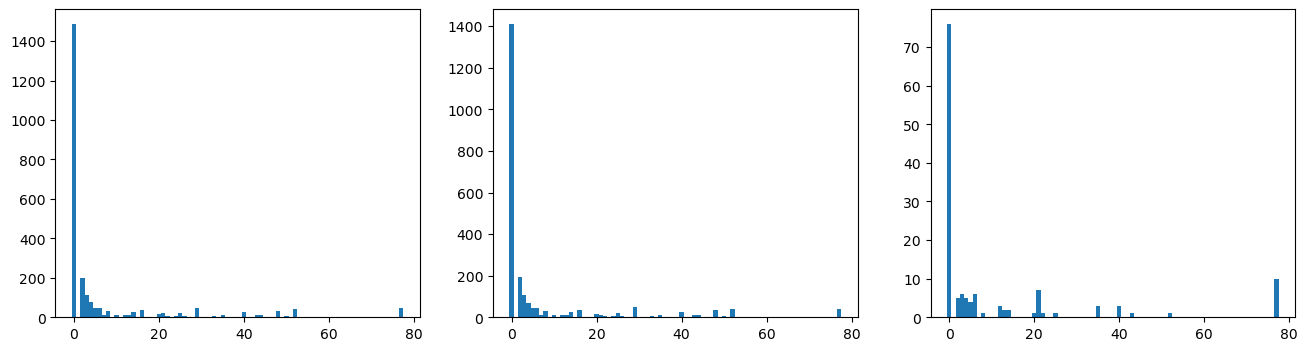

In [27]:
def plot_family(df, ax=None):
    fams = []
    for digest in list(df['DigestHex']):
        desc = next(parse_file(glob(f'./../archive/microdescs-2021-11/micro/*/*/{digest.lower()}')[0]))
        fams.append(len(desc.family))  
    fams = np.array(fams)
    if ax is None:
        ax = plt
    ax.hist(fams, np.arange(0, fams.max() + 1.5) - 0.5)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plot_family(c.df[c.df.index.isin(mod_guards)], ax=axes[0])
plot_family(c.df[c.df.index.isin(torps_guards)], ax=axes[1])
plot_family(c.df[c.df.index.isin(mod_guards) & ~c.df.index.isin(torps_guards)], ax=axes[2])
plt.show()

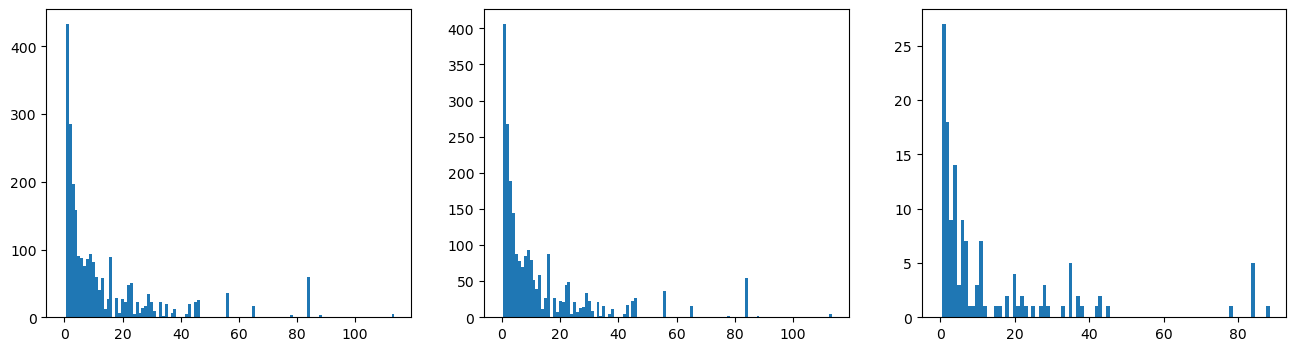

In [28]:
def plot_subnet(df, ax=None):
    subnet = []
    for count in list(df['SubnetCount']):
        subnet.append(count)    
    subnet = np.array(subnet)
    if ax is None:
        ax = plt
    ax.hist(subnet, np.arange(0, subnet.max() + 1.5) - 0.5)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plot_subnet(c.df[c.df.index.isin(mod_guards)], ax=axes[0])
plot_subnet(c.df[c.df.index.isin(torps_guards)], ax=axes[1])
plot_subnet(c.df[c.df.index.isin(mod_guards) & ~c.df.index.isin(torps_guards)], ax=axes[2])
plt.show()

<AxesSubplot: ylabel='Frequency'>

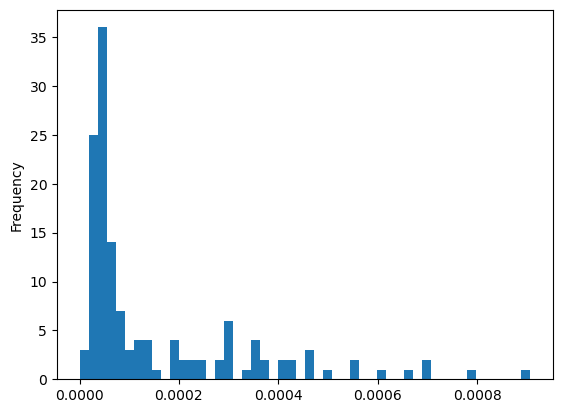

In [29]:
c.df[c.df.index.isin(mod_guards) & ~c.df.index.isin(torps_guards)]['ProbForGuard'].plot.hist(bins=50)

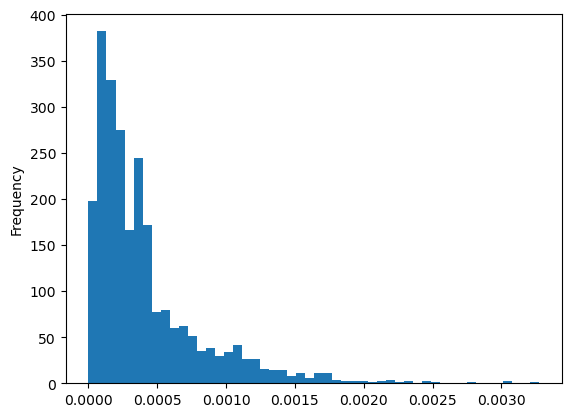

In [30]:
c.df[c.df.index.isin(mod_guards)]['ProbForGuard'].plot.hist(bins=50)
plt.show()

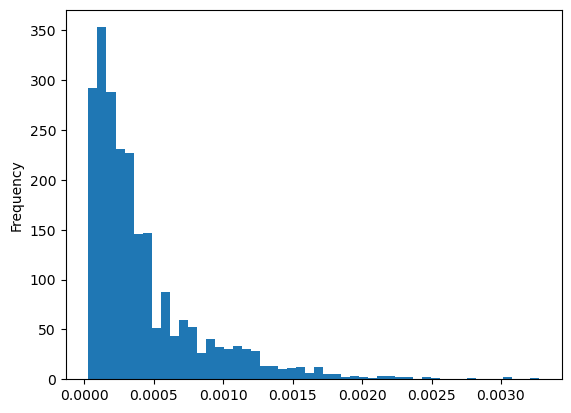

In [31]:
c.df[c.df.index.isin(torps_guards)]['ProbForGuard'].plot.hist(bins=50)
plt.show()

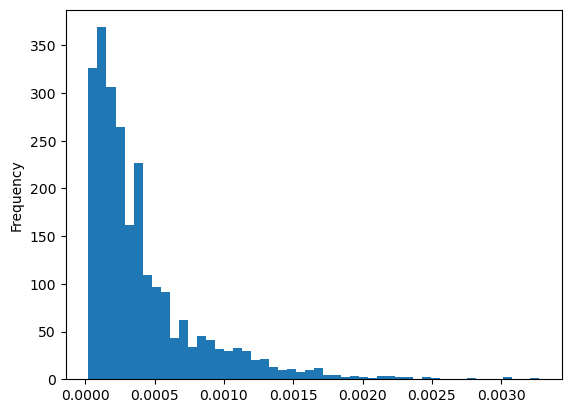

In [32]:
c.df[c.df.index.isin(sim_guards)]['ProbForGuard'].plot.hist(bins=50)
plt.show()

In [33]:
pd.concat([
    torps_stats[1].create_table(),
    tormod_stats[1].create_table(),
    sim_stats[1].create_table(),
]).T

Date                               2021-11-02 00:00:00  2021-11-02 00:02:00  \
Total Circuits                            96876.000000         96877.000000   
Total Links                              185399.000000        185527.000000   
Shared Links                               7478.000000          7386.000000   
Unshared Links                           177921.000000        178141.000000   
Shared Links Percent                          4.033463             3.981092   
Total Circuit Parts                      193752.000000        193754.000000   
Shared Circuit Parts                      15831.000000         15613.000000   
Unshared Circuit Parts                   177921.000000        178141.000000   
Shared Circuit Parts Percent                  8.170754             8.058156   
Total Guard-Middle Links                  94125.000000         94239.000000   
Shared Guard-Middles Links                 2587.000000          2485.000000   
Unshared Guard-Middles Links              91538.000000         91754.000000   
Shared Guard-Middles Percent                  2.748473             2.636913   
Total Middle-Exits Links                  91274.000000         91291.000000   
Shared Middle-Exits Links                  4891.000000          4898.000000   
Unshared Middle-Exits Links               86383.000000         86393.000000   
Shared Middle-Exits Links Percent             5.358591             5.365261   
Complete Shared Circuits                      3.000000             3.000000   
Relays                                     5652.000000          5742.000000   
Guards                                     2308.000000          2446.000000   
Middles                                    4393.000000          4474.000000   
Exits                                      1245.000000          1249.000000   
Consensus Relays                                   NaN                  NaN   
Consensus Guards                                   NaN                  NaN   
Consensus Middles                                  NaN                  NaN   
Consensus Exits                                    NaN                  NaN   

Date                               2021-11-02 00:00:00  
Total Circuits                            96876.000000  
Total Links                              185460.000000  
Shared Links                               7457.000000  
Unshared Links                           178003.000000  
Shared Links Percent                          4.020813  
Total Circuit Parts                      193752.000000  
Shared Circuit Parts                      15749.000000  
Unshared Circuit Parts                   178003.000000  
Shared Circuit Parts Percent                  8.128432  
Total Guard-Middle Links                  94179.000000  
Shared Guard-Middles Links                 2545.000000  
Unshared Guard-Middles Links              91634.000000  
Shared Guard-Middles Percent                  2.702301  
Total Middle-Exits Links                  91281.000000  
Shared Middle-Exits Links                  4912.000000  
Unshared Middle-Exits Links               86369.000000  
Shared Middle-Exits Links Percent             5.381186  
Complete Shared Circuits                      7.000000  
Relays                                     5732.000000  
Guards                                     2441.000000  
Middles                                    4444.000000  
Exits                                      1262.000000  
Consensus Relays                           6703.000000  
Consensus Guards                           2444.000000  
Consensus Middles                          5407.000000  
Consensus Exits                            1289.000000

## Results

There is no pattern directly observable, but TorPS selects less relays in the guard ($144 \pm 40$) and middle ($44 \pm 13$) position

In [34]:
guards = []
middles = []
exits = []
for i in range(len(torps_stats)):
    t1 = torps_stats[i].create_table()       
    t2 = sim_stats[i].create_table()
      
    guards.append(int(t2['Guards']) - int(t1['Guards']))
    middles.append(int(t2['Middles']) - int(t1['Middles']))
    exits.append(int(t2['Exits']) - int(t1['Exits']))
    
    
print(np.mean(np.array(guards)), np.std(np.array(guards)))
print(np.mean(np.array(middles)), np.std(np.array(middles)))
print(np.mean(np.array(exits)), np.std(np.array(exits)))

144.79310344827587 41.08559552123015
41.206896551724135 18.850371459515387
10.758620689655173 4.811302586645492


In [35]:
guards = []
middles = []
exits = []
for i in range(len(torps_stats)):
    t1 = sim_stats[i].create_table()       
    t2 = tormod_stats[i].create_table()
      
    guards.append(int(t2['Guards']) - int(t1['Guards']))
    middles.append(int(t2['Middles']) - int(t1['Middles']))
    exits.append(int(t2['Exits']) - int(t1['Exits']))
    
    
print(np.mean(np.array(guards)), np.std(np.array(guards)))
print(np.mean(np.array(middles)), np.std(np.array(middles)))
print(np.mean(np.array(exits)), np.std(np.array(exits)))

3.8275862068965516 2.666121624838304
12.931034482758621 20.708037810578002
1.3793103448275863 6.138705879027218


# Compare Tools -- Plots for Paper

In [36]:
table = pd.DataFrame(table)
table

Name  Total Circuits  Shared Links Percent
0     TorPS         96876.0              4.134863
1     TorPS         96876.0              4.033463
2     TorPS         96876.0              3.961479
3     TorPS         96876.0              3.747502
4     TorPS         96876.0              3.710327
5     TorPS         96876.0              3.924228
6     TorPS         96876.0              3.958839
7     TorPS         96876.0              3.804479
8     TorPS         96876.0              4.347567
9     TorPS         96876.0              4.409534
10    TorPS         96876.0              4.468680
11    TorPS         96876.0              4.424822
12    TorPS         96876.0              4.436954
13    TorPS         96876.0              4.366309
14    TorPS         96876.0              4.486749
15    TorPS         96876.0              4.577476
16    TorPS         96876.0              4.393112
17    TorPS         96876.0              4.392600
18    TorPS         96876.0              4.363591
19    TorPS         96876.0              4.583625
20    TorPS         96876.0              4.499022
21    TorPS         96876.0              4.394337
22    TorPS         96876.0              4.340628
23    TorPS         96876.0              4.162754
24    TorPS         96876.0              4.066509
25    TorPS         96876.0              4.075142
26    TorPS         96876.0              3.878858
27    TorPS         96876.0              3.933431
28    TorPS         96876.0              3.801195
29   ModTor         96877.0              4.095300
30   ModTor         96877.0              3.981092
31   ModTor         96877.0              3.805575
32   ModTor         96877.0              3.621805
33   ModTor         96877.0              3.670296
34   ModTor         96877.0              3.746151
35   ModTor         96877.0              3.787651
36   ModTor         96877.0              3.613023
37   ModTor         96877.0              4.055701
38   ModTor         96877.0              4.260818
39   ModTor         96877.0              4.347285
40   ModTor         96877.0              4.287784
41   ModTor         96877.0              4.229509
42   ModTor         96877.0              4.355665
43   ModTor         96877.0              4.356558
44   ModTor         96877.0              4.342648
45   ModTor         96877.0              4.264647
46   ModTor         96877.0              4.255377
47   ModTor         96877.0              4.097406
48   ModTor         96877.0              4.353567
49   ModTor         96877.0              4.311524
50   ModTor         96877.0              4.193040
51   ModTor         96877.0              4.118326
52   ModTor         96877.0              4.023153
53   ModTor         96877.0              3.925495
54   ModTor         96877.0              4.051687
55   ModTor         96877.0              3.710065
56   ModTor         96877.0              3.849855
57   ModTor         96877.0              3.696151
58   ModTor         96877.0              3.655168
59    SALSA         96876.0              4.104415
60    SALSA         96876.0              4.020813
61    SALSA         96876.0              3.852817
62    SALSA         96876.0              3.586465
63    SALSA         96876.0              3.723176
64    SALSA         96876.0              3.733620
65    SALSA         96876.0              3.803851
66    SALSA         96876.0              3.685030
67    SALSA         96876.0              4.088967
68    SALSA         96876.0              4.204125
69    SALSA         96876.0              4.170066
70    SALSA         96876.0              4.253042
71    SALSA         96876.0              4.263153
72    SALSA         96876.0              4.293190
73    SALSA         96876.0              4.297760
74    SALSA         96876.0              4.401943
75    SALSA         96876.0              4.252617
76    SALSA         96876.0              4.184331
77    SALSA         96876.0              4.117698
78    SALSA         96876.0              4.396253
79    S

In [37]:
table.groupby('Name').mean()

Total Circuits  Shared Links Percent
Name                                        
ModTor         96877.0              4.035411
Pseudo             0.0              4.002653
SALSA          96876.0              4.030272
TorPS          96876.0              4.195796

In [38]:
table.groupby('Name').count()

Total Circuits  Shared Links Percent
Name                                        
ModTor              30                    30
Pseudo              30                    30
SALSA               30                    30
TorPS               29                    29

In [39]:
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

In [40]:
def format_percent(x, pos=None, digits=2, xmax=100):
    x = x / xmax * 100
    format_string = '%%.%df %%%%' % digits
    return format_string % x

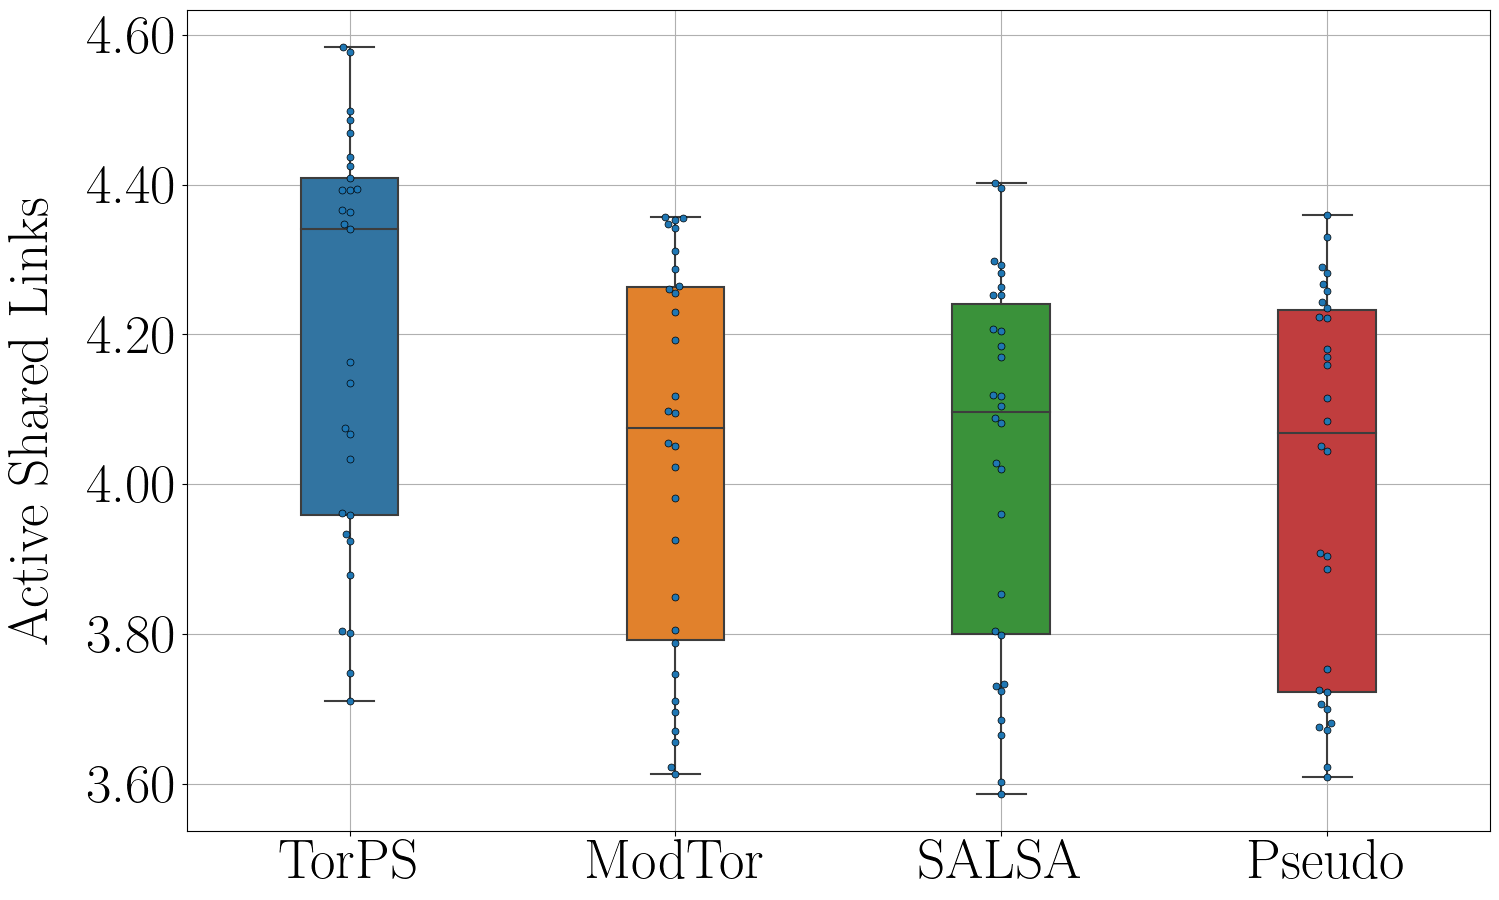

In [41]:
plt.rc('font', family='cmr10')
plt.rc('font', size=40)
plt.rc('axes', axisbelow=True)
plt.rc('axes.formatter', use_mathtext=True)

plt.figure(figsize=(16, 10))
sns.boxplot(x='Name', y='Shared Links Percent', width=0.3, data=table)
sns.swarmplot(x='Name', y='Shared Links Percent', data=table, edgecolor='black', color='black', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(format_percent)
plt.xlabel(None)
plt.ylabel('Active Shared Links', labelpad=20)
plt.gca().grid(True)
plt.tight_layout()
plt.show()

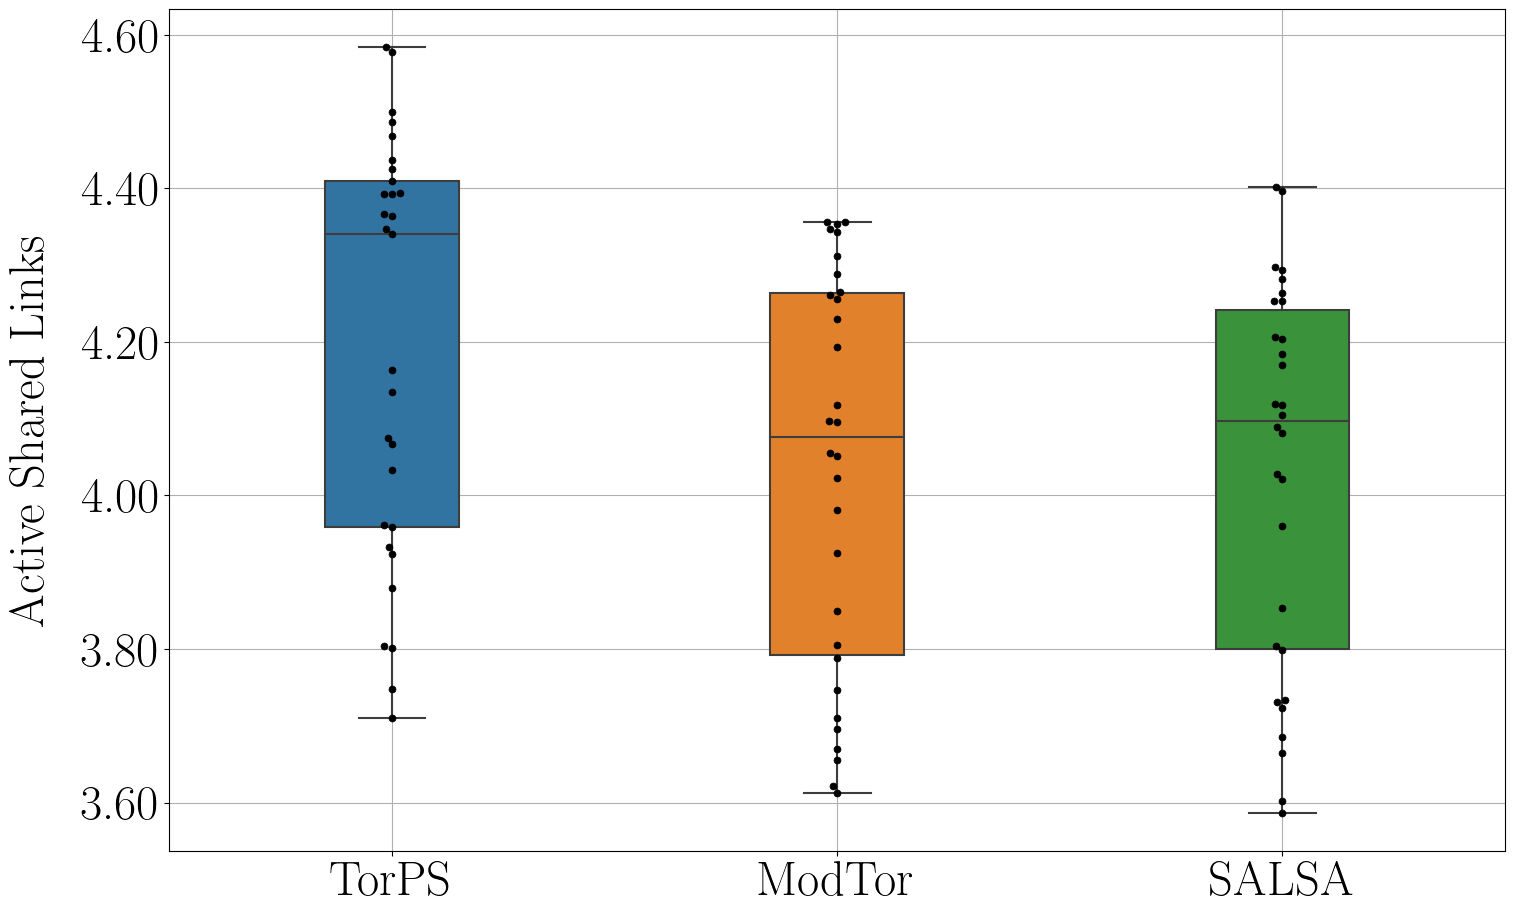

In [46]:
plt.rc('font', family='cmr10')
plt.rc('font', size=35)
plt.rc('axes', axisbelow=True)
plt.rc('axes.formatter', use_mathtext=True)

table = table[table['Name'] != 'Pseudo']

plt.figure(figsize=(16, 10))
sns.boxplot(x='Name', y='Shared Links Percent', width=0.3, data=table)
sns.swarmplot(x='Name', y='Shared Links Percent', data=table, edgecolor='black', color='black', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(format_percent)
plt.xlabel(None)
plt.ylabel('Active Shared Links', labelpad=20)
plt.gca().grid(True)
plt.tight_layout()
plt.savefig('paper-compare-tools.pdf')
plt.show()